# Multitaper and Hamonic Ftest


,Time:512Hz,Epoch,FP1,FP2,F7,Fz,F8,T3,C3,Cz,C4,T4,T5,Pz,T6,O1,O2,Event Id,Event Date,Event Duration
66560,0.000000,2080,27205.742188,20234.777344,67254.585938,50280.292969,46816.976562,38356.753906,42724.351562,44819.644531,41129.207031,36889.632812,29754.621094,61423.636719,49412.121094,46200.183594,49307.640625,NaN,NaN,NaN
66561,0.001953,2080,27519.830078,20514.810547,67606.359375,50538.355469,47171.621094,38711.000000,43072.554688,45157.378906,41474.246094,37243.652344,30099.775391,61764.968750,49771.234375,46546.535156,49667.789062,NaN,NaN,NaN
66562,0.003906,2080,27337.244141,20326.822266,67412.875000,50488.886719,46990.550781,38533.039062,42911.339844,44994.472656,41296.792969,37044.800781,29930.175781,61602.785156,49597.847656,46397.558594,49521.761719,NaN,NaN,NaN
66563,0.005859,2080,27073.406250,20089.857422,67127.554688,50254.304688,46708.796875,38244.582031,42627.203125,44717.750000,41020.019531,36763.894531,29650.212891,61321.828125,49308.804688,46111.898438,49228.261719,NaN,NaN,NaN
66564,0.007812,2080,26796.884766,19850.929688,66815.039062,49990.011719,46396.414062,37925.113281,42311.265625,44415.046875,40711.941406,36451.796875,29333.869141,61007.468750,48986.546875,45787.925781,48895.351562,NaN,NaN,NaN


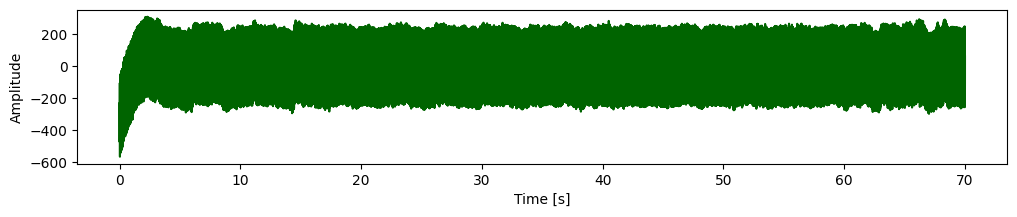

In [60]:
import numpy as np
import pandas as pd
from scipy import signal
from multitaper import MultiTaper_Periodogram
import matplotlib.pyplot as plt


df = pd.read_csv("../../test_data/record.csv")
df = df[(df["Time:512Hz"] >= 130) & (df["Time:512Hz"] <= 200)]
df["Time:512Hz"] = df["Time:512Hz"] - df["Time:512Hz"].iloc[0]
display(df.head())
fs_EEG =512
signal_EEG = df["C3"].to_numpy()
time_EEG = df["Time:512Hz"].to_numpy()


def lowpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  # フィルタのオーダーと正規化周波数を計算
    b, a = signal.butter(N, Wn, btype="low")     # ハイパスフィルターを設計
    y = signal.filtfilt(b, a, x)                  # フィルタ適用（ゼロ位相遅延）
    return y                                      # フィルタ後の信号を返す
def highpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  # フィルタのオーダーと正規化周波数を計算
    b, a = signal.butter(N, Wn, btype="high")     # ハイパスフィルターを設計
    y = signal.filtfilt(b, a, x)                  # フィルタ適用（ゼロ位相遅延）
    return y                                      # フィルタ後の信号を返す
def bandpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "band")           #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y    

# ハイパスフィルターの設定
cutoff = 0.2  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 20    # 阻止域最小減衰[dB]
signal_EEG = highpass(signal_EEG, fs_EEG, cutoff, gpass, gstop)


cutoff = 60  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
signal_EEG = lowpass(signal_EEG, fs_EEG, cutoff, gpass, gstop)

notch_freq = 50
Q = 40
b, a = signal.iirnotch(notch_freq, Q, fs_EEG)
# signal_EEG = signal.filtfilt(b, a, signal_EEG)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(time_EEG, signal_EEG, color='darkgreen')
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time [s]")
plt.show()

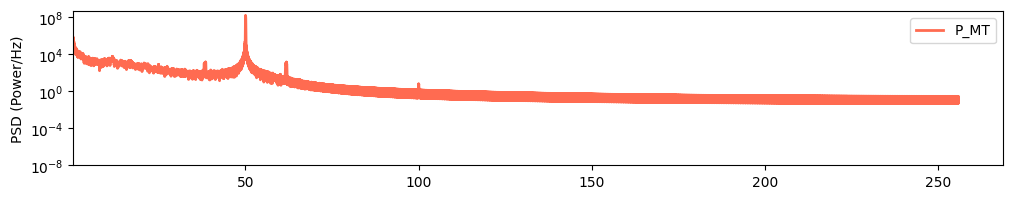

[0.00000000e+00 7.81250000e-03 1.56250000e-02 ... 2.55976562e+02
 2.55984375e+02 2.55992188e+02]


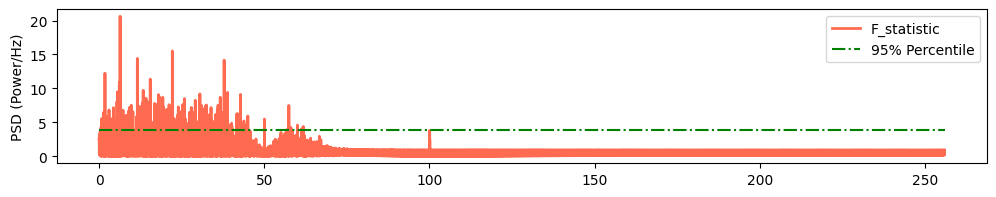

In [43]:
MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16)
MTSpec.MT_Spec(signal_EEG, fs_EEG)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95
ax.plot(MTSpec.f, MTSpec.mt_psd, '-',label='P_MT',alpha=a,  c ='tomato',lw=2)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_xscale('log')
ax.set_xlim(0.1)
ax.set_yscale('log')
ax.set_ylim(1e-8)
plt.legend()
plt.show()


MTSpec.Harmonic_Ftest(p_level=0.05)
print(MTSpec.f)
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95
ax.plot(MTSpec.f, MTSpec.F, '-',label='F_statistic',alpha=a,  c ='tomato',lw=2)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_xscale('log')
# ax.set_xlim(-5,5)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
plt.legend()
plt.show()

,Time,PPG,ECG,resp
0,0.000,1.360704,0.455078,1.750153
1,0.008,1.394917,0.404785,1.750153
2,0.016,1.444770,0.339844,1.750153
3,0.024,1.508309,0.300293,1.750153
4,0.032,1.581623,0.285156,1.624924


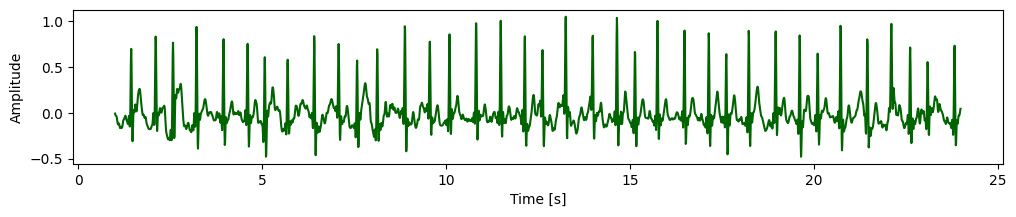

In [59]:
df_ecg = pd.read_csv("../../test_data/ECG_data.csv")

display(df_ecg.head())
fs_ECG = 125
signal_ecg = df_ecg["ECG"].iloc[125:3000].to_numpy()
time_ecg = df_ecg["Time"].iloc[125:3000].to_numpy()


def highpass(x, samplerate, cutoff, gpass, gstop):
    fn = samplerate / 2                           # ナイキスト周波数
    wp = cutoff / fn                              # 通過域端周波数（正規化）
    ws = (cutoff * 0.5) / fn                      # 阻止域端周波数（正規化、少し低めに設定）
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  # フィルタのオーダーと正規化周波数を計算
    b, a = signal.butter(N, Wn, btype="high")     # ハイパスフィルターを設計
    y = signal.filtfilt(b, a, x)                  # フィルタ適用（ゼロ位相遅延）
    return y                                      # フィルタ後の信号を返す

# ハイパスフィルターの設定
cutoff = 1.0  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
signal_ecg = highpass(signal_ecg, fs_ECG, cutoff, gpass, gstop)

cutoff = 20  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
signal_ecg = lowpass(signal_ecg, fs_ECG, cutoff, gpass, gstop)

fig = plt.figure(1, figsize=(12,2))
ax = fig.add_subplot()
ax.plot(time_ecg, signal_ecg, color='darkgreen')
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time [s]")
plt.show()

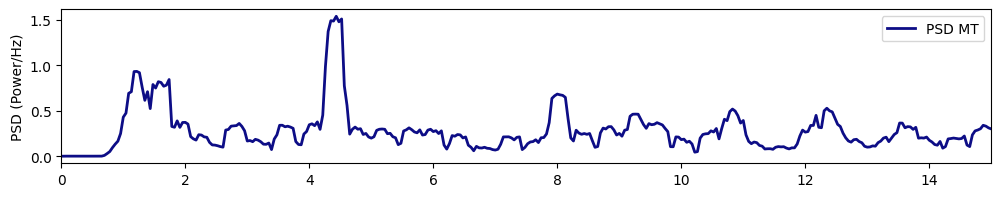

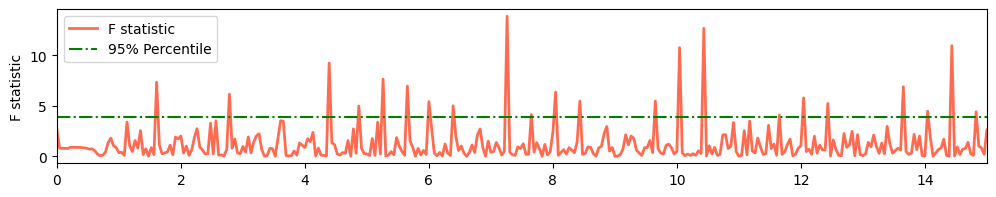

In [45]:
MTSpec = MultiTaper_Periodogram(NW=4)
MTSpec.MT_Spec(signal_ecg, fs_ECG)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95
ax.plot(MTSpec.f, MTSpec.mt_psd, '-',label='PSD MT',alpha=a,  c ='navy',lw=2)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_xscale('log')
ax.set_xlim(0,15)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
plt.legend()
plt.show()


MTSpec.Harmonic_Ftest(p_level=0.05)
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95

ax.plot(MTSpec.f, MTSpec.F, '-',label='F statistic',alpha=a,  c ='tomato',lw=2)
ax.set_ylabel('F statistic')
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')

# ax.set_xscale('log')
ax.set_xlim(0,15)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
plt.legend()
plt.show()

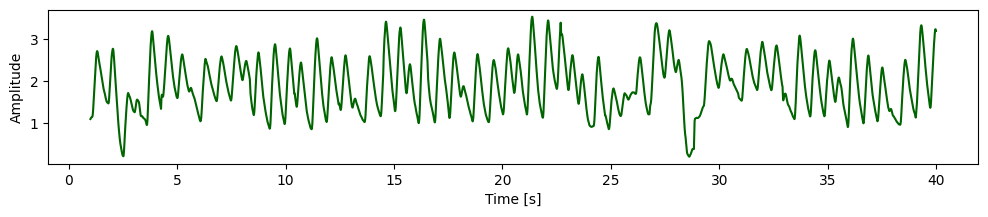

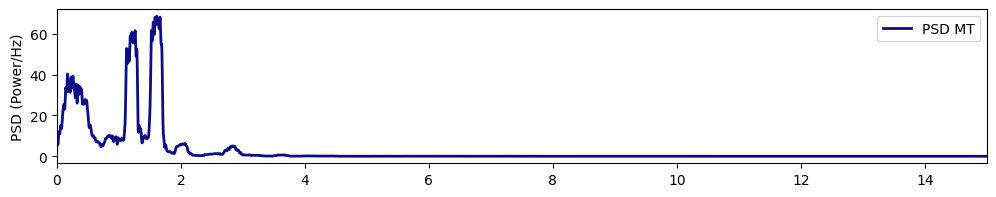

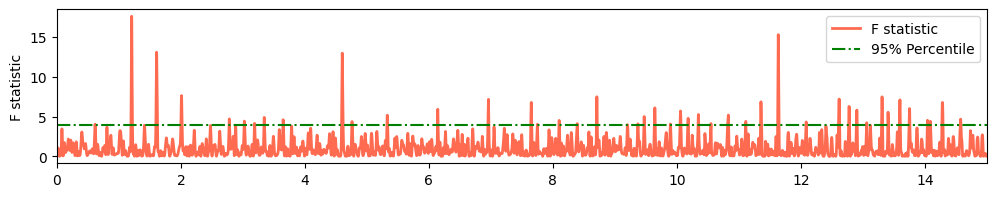

In [58]:
signal_ppg = df_ecg["PPG"].iloc[125:5000].to_numpy()
time_ppg = df_ecg["Time"].iloc[125:5000].to_numpy()

# signal_ppg = highpass(signal_ppg, fs_ECG, cutoff, gpass, gstop)
# signal_ppg = lowpass(signal_ppg, fs_ECG, cutoff, gpass, gstop)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
ax.plot(time_ppg, signal_ppg, color='darkgreen')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
plt.show()

MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16)
MTSpec.MT_Spec(signal_ppg, fs_ECG)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95
ax.plot(MTSpec.f, MTSpec.mt_psd, '-',label='PSD MT',alpha=a,  c ='navy',lw=2)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_xscale('log')
ax.set_xlim(0,15)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
plt.legend()
plt.show()


MTSpec.Harmonic_Ftest(p_level=0.05)
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95

ax.plot(MTSpec.f, MTSpec.F, '-',label='F statistic',alpha=a,  c ='tomato',lw=2)
ax.set_ylabel('F statistic')
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')

# ax.set_xscale('log')
ax.set_xlim(0,15)
# ax.set_yscale('log')
# ax.set_ylim(0,40)
plt.legend()
plt.show()

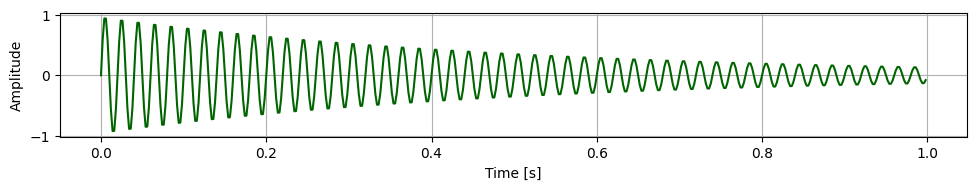

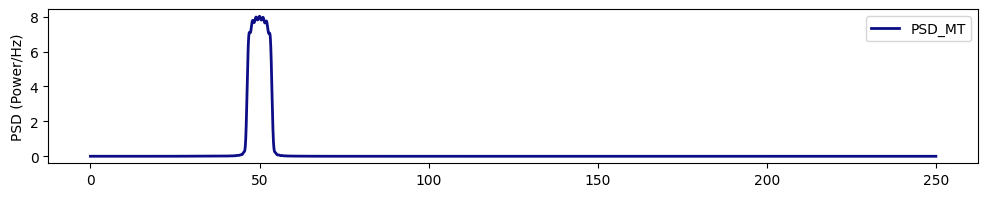

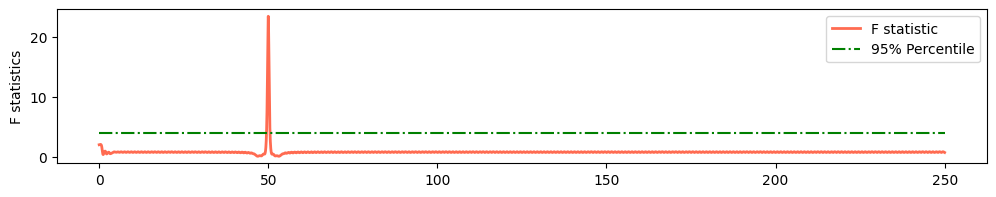

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import math


# パラメータ設定
fs_e = 500  # サンプリング周波数 (Hz)
t = np.linspace(0, 1, fs_e, endpoint=False)  # 時間軸（1秒間分のデータ）

f = 50  # 振動の周波数 (Hz)
decay_rate = 2  # 減衰率（大きいほど早く減衰）

# 減衰振動の生成
amplitude = np.exp(-decay_rate * t)  # 減衰を表す指数関数
oscillation = np.sin(2 * np.pi * f * t)  # 正弦波
# oscillation = np.clip(oscillation, -0.6, 0.6)
am_signal = amplitude * oscillation  # 減衰振動

# noisy_am_signal = am_signal
# プロット
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot()
ax.plot(t, am_signal, label="AM Signal", color='darkgreen')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.grid()
plt.tight_layout()
plt.show()


MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16)
MTSpec.MT_Spec(am_signal, fs_e)

fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95
ax.plot(MTSpec.f, MTSpec.mt_psd, '-',label='PSD_MT',alpha=a,  c ='navy',lw=2)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_xscale('log')
# ax.set_xlim(0,5)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
plt.legend()
plt.show()


MTSpec.Harmonic_Ftest(p_level=0.05)
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95
ax.plot(MTSpec.f, MTSpec.F, '-',label='F statistic',alpha=a,  c ='tomato',lw=2)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F statistics')
# ax.set_xscale('log')
# ax.set_xlim(-5,5)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
plt.legend()
plt.show()

0th 31.846204939911424
1th 12292172.824381491
2th 46.7258663942115
3th 396588.68052796286
4th 56.94723260025239
5th 29529.60206368757
6th 71.54357530964185


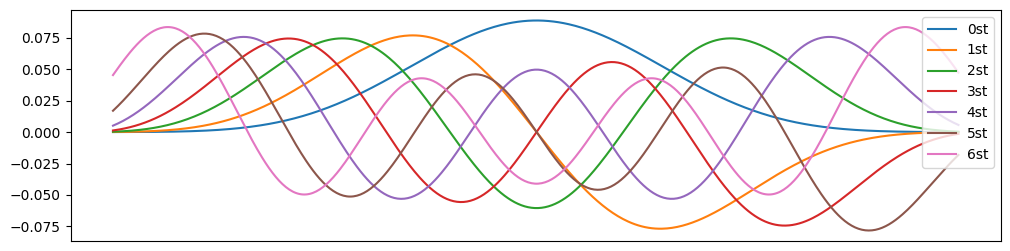

In [54]:
plt.figure(figsize=(12, 3))

for k_i in range(MTSpec.K):
    # k_i 番目のターパー
    plt.plot(MTSpec.k_DPSS[k_i, :], label=f'{k_i}st') 
    print(f"{k_i}th {1/(sum(MTSpec.k_DPSS[k_i, :])/fs_e)}")

plt.xticks([])
# plt.grid()
plt.legend(loc='upper right')
plt.show()


['EEG', 'suppl_info']


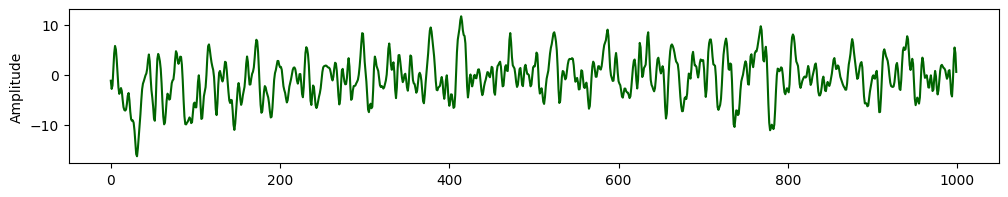

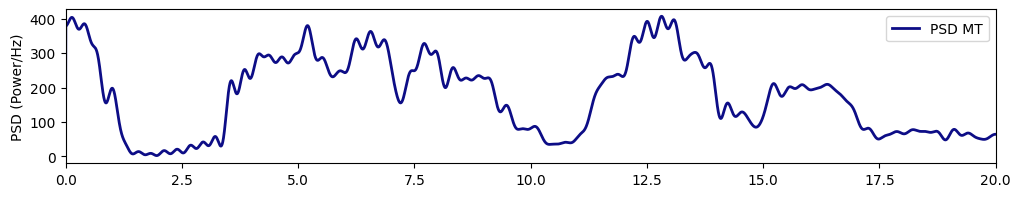

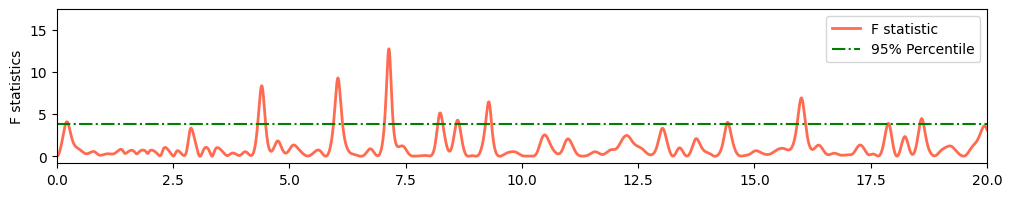

In [56]:
import scipy.io as sio
import pandas as pd

mat_data = sio.loadmat(
    '../../test_data/S16.mat',
    struct_as_record=False,
    squeeze_me=True
)

# (1,1) shape の struct: 例: data -> mat_struct
data_struct = mat_data["data"]  # これが mat_struct

# フィールド一覧を確認
print(data_struct._fieldnames)  # 例: ['EEG', 'suppl_info']

# フィールドへアクセス
EEG = getattr(data_struct, "EEG")         # data_struct.EEG と同等
info = getattr(data_struct, "suppl_info") # data_struct.suppl_info と同等

# Pz:48 O1 61
ssvep = EEG[48,:,0,1]
fs_vep = 256

# ハイパスフィルターの設定
cutoff = 0.2  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 20    # 阻止域最小減衰[dB]
ssvep = highpass(ssvep, fs_vep, cutoff, gpass, gstop)


cutoff = 60  # 0.5Hzのカットオフ周波数
gpass = 3     # 通過域最大損失[dB]
gstop = 40    # 阻止域最小減衰[dB]
ssvep = lowpass(ssvep, fs_vep, cutoff, gpass, gstop)


fig = plt.figure(1, figsize=(12,2))
ax = fig.add_subplot()
ax.plot(ssvep, color='darkgreen')
ax.set_ylabel("Amplitude")
plt.show()

MTSpec = MultiTaper_Periodogram(NW=4,nfft=2**16)
MTSpec.MT_Spec(ssvep, fs_vep)
fig = plt.figure(1, figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95
ax.plot(MTSpec.f, MTSpec.mt_psd, '-',label='PSD MT',alpha=a,  c ='navy',lw=2)
ax.set_ylabel('PSD (Power/Hz)')
# ax.set_xscale('log')
ax.set_xlim(0,20)
# ax.set_yscale('log')
# ax.set_ylim(1e-10)
plt.legend()
plt.show()


MTSpec.Harmonic_Ftest(p_level=0.05)
fig = plt.figure(figsize=(12, 2))
ax = fig.add_subplot()
a = 0.95
ax.plot(MTSpec.f, MTSpec.F, '-',label='F statistic',alpha=a,  c ='tomato',lw=2)
ax.hlines(MTSpec.F_crit, MTSpec.f[0], MTSpec.f[-1], linestyles="-.", color='green', label='95% Percentile')
ax.set_ylabel('F statistics')
# ax.set_xscale('log')
ax.set_xlim(0,20)
# ax.set_yscale('log')
# ax.set_ylim(1e-8)
plt.legend()
plt.show()